In [68]:
#Imports
import sqlite3 as sql
import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [7]:
import os
print(os.getcwd())

/Users/blakelaw/PycharmProjects/RefereeAnalysis


In [8]:
conn = sql.connect('nba.sqlite') # create connection object to database
conn

In [9]:
df = pd.read_sql('select * from combined_all2', conn)

In [10]:
df.to_csv('df.csv')

In [11]:
home_games = df[['team_abbreviation_home','game_id', 'game_date', 'official_id', 'team_id_home', 'pts_home', 'first_name', 'last_name']].rename(columns={'team_abbreviation_home': 'team_abbreviation','team_id_home': 'team_id', 'pts_home': 'pts'})
away_games = df[['team_abbreviation_away','game_id', 'game_date', 'official_id', 'team_id_away', 'pts_away','first_name', 'last_name']].rename(columns={'team_abbreviation_away': 'team_abbreviation', 'team_id_away': 'team_id', 'pts_away': 'pts'})


In [12]:
combined = pd.concat([home_games, away_games], axis=0)

In [13]:
grouped_df = combined.groupby(['official_id', 'team_abbreviation']).agg(avg_pts=('pts', 'mean'), num_games=('pts', 'size')).reset_index()

In [14]:
grouped_df

,official_id,team_abbreviation,avg_pts,num_games
0,101283,ATL,105.885246,61
1,101283,BKN,104.575000,40
2,101283,BOS,104.682540,63
3,101283,CHA,97.381818,55
4,101283,CHI,100.627119,59
...,...,...,...,...
2847,2882,SAS,105.885246,61
2848,2882,SEA,91.500000,10
2849,2882,TOR,104.353846,65
2850,2882,UTA,101.875000,56


In [15]:
expanded_df = grouped_df.merge(combined[['official_id', 'first_name', 'last_name']], on='official_id', how='left')


In [16]:
expanded_df

,official_id,team_abbreviation,avg_pts,num_games,first_name,last_name
0,101283,ATL,105.885246,61,Brian,Forte
1,101283,ATL,105.885246,61,Brian,Forte
2,101283,ATL,105.885246,61,Brian,Forte
3,101283,ATL,105.885246,61,Brian,Forte
4,101283,ATL,105.885246,61,Brian,Forte
...,...,...,...,...,...,...
4173351,2882,WAS,105.348485,66,Sean,Wright
4173352,2882,WAS,105.348485,66,Sean,Wright
4173353,2882,WAS,105.348485,66,Sean,Wright
4173354,2882,WAS,105.348485,66,Sean,Wright


In [17]:
expanded_df = expanded_df.drop_duplicates()
expanded_df = expanded_df.rename(columns={'avg_pts': 'avg_pts_ref'})

In [18]:
avg = combined.groupby('team_abbreviation')['pts'].mean().reset_index()
avg = avg.rename(columns={'pts': 'avg_score'})

In [19]:
expanded_df = expanded_df.merge(avg, on='team_abbreviation', how='left')

# Rename the 'avg_score' column from 'new_table' to 'avg_team_score'
expanded_df = expanded_df.rename(columns={'avg_score': 'avg_pts_team'})

In [93]:
expanded_df['score_difference'] = expanded_df['avg_pts_ref'] - expanded_df['avg_pts_team']
expanded_df['abs_score_difference'] = expanded_df['score_difference'].abs()

In [92]:
expanded_df_30 = expanded_df[expanded_df['num_games'] > 30].reset_index()
expanded_df_30 = expanded_df_30.sort_values(by='abs_score_difference', ascending=False)

In [56]:
diagram = expanded_df_30.head(10)[['team_abbreviation', 'first_name', 'last_name', 'num_games', 'avg_pts_team', 'avg_pts_ref', 'score_difference', 'abs_score_difference']]
diagram.insert(3, 'Full Name', diagram['first_name'] + ' ' + diagram['last_name'])

diagram = diagram.rename(columns={
    'team_abbreviation': 'Team',
    'num_games': 'Games',
    'avg_pts_team': 'Team Average',
    'avg_pts_ref': 'Ref Average',
    'score_difference': 'Difference',
    'abs_score_difference': 'Absolute Difference'
})
diagram

,Team,first_name,last_name,Full Name,Games,Team Average,Ref Average,Difference,Absolute Difference
1700,WAS,Gediminas,Petraitis,Gediminas Petraitis,33,101.944863,117.696970,15.752107,15.752107
954,MIN,Aaron,Smith,Aaron Smith,31,101.570768,115.000000,13.429232,13.429232
1677,LAC,Dedric,Taylor,Dedric Taylor,36,102.615403,115.027778,12.412375,12.412375
1699,POR,Gediminas,Petraitis,Gediminas Petraitis,36,101.471829,113.694444,12.222615,12.222615
1587,POR,Kevin,Scott,Kevin Scott,39,101.471829,112.974359,11.502530,11.502530
1704,MIL,Tyler,Ford,Tyler Ford,32,102.275704,112.937500,10.661796,10.661796
334,LAC,Kevin,Fehr,Kevin Fehr,42,102.615403,92.000000,-10.615403,10.615403
1702,IND,Tyler,Ford,Tyler Ford,34,101.374695,111.882353,10.507658,10.507658
1674,SAC,Mitchell,Ervin,Mitchell Ervin,31,103.970955,114.193548,10.222593,10.222593
1673,PHI,Mitchell,Ervin,Mitchell Ervin,32,100.098025,110.093750,9.995725,9.995725


In [23]:
Ged_Games = combined[(combined['first_name']=='Gediminas') & (combined['team_abbreviation']=='WAS')][['game_date','pts']]
WAS = combined[combined['team_abbreviation']=='WAS'][['game_date','pts']]

Ged_Games = Ged_Games.drop_duplicates()
WAS = WAS.drop_duplicates()

WAS['game_date'] = pd.to_datetime(WAS['game_date'])
Ged_Games['game_date'] = pd.to_datetime(Ged_Games['game_date'])

In [24]:
Ged_Games.to_csv('Ged_Games.csv')
WAS.to_csv('WAS.csv')

In [25]:
diff = expanded_df_30['score_difference'].round().astype(int)

In [26]:
diff.to_csv('diff.csv')

In [27]:
combined['game_date'] = pd.to_datetime(combined['game_date'])
combined['year'] = combined['game_date'].dt.year

In [28]:
avg2 = combined.groupby(['year', 'team_abbreviation'])['pts'].mean().reset_index()
avg2 = avg2.rename(columns={'pts': 'avg_score'})

In [29]:
combined = pd.merge(combined, avg2,  how='left', left_on=['year','team_abbreviation'], right_on = ['year','team_abbreviation'])
combined['score_diff'] = combined['pts'] - combined['avg_score']

In [30]:
avg_diff = combined.groupby(['official_id', 'team_abbreviation'])['score_diff'].mean().reset_index()

In [31]:
num_games = combined.groupby(['official_id', 'team_abbreviation']).size().reset_index(name='num_games')

referee_names = combined[['official_id', 'first_name', 'last_name']].drop_duplicates()
referee_names['referee_name'] = referee_names['first_name'] + ' ' + referee_names['last_name']
referee_names = referee_names[['official_id', 'referee_name']].drop_duplicates()

avg_diff = pd.merge(avg_diff, num_games,  how='left', on=['official_id', 'team_abbreviation'])
avg_diff = pd.merge(avg_diff, referee_names, how='left', on='official_id')
avg_diff['abs_score_difference'] = avg_diff['score_diff'].abs()

In [32]:
combined[(combined['team_abbreviation'] == 'NJN') & (combined['official_id'] == '202049')]

,team_abbreviation,game_id,game_date,official_id,team_id,pts,first_name,last_name,year,avg_score,score_diff
29220,NJN,0021100360,2012-02-06,202049,1610612751,87,Ben,Taylor,2012,93.494318,-6.494318


In [33]:
avg_diff

,official_id,team_abbreviation,score_diff,num_games,referee_name,abs_score_difference
0,101283,ATL,0.164631,61,Brian Forte,0.164631
1,101283,BKN,-0.919404,40,Brian Forte,0.919404
2,101283,BOS,-0.895299,63,Brian Forte,0.895299
3,101283,CHA,-2.453807,55,Brian Forte,2.453807
4,101283,CHI,-1.350248,59,Brian Forte,1.350248
...,...,...,...,...,...,...
2847,2882,SAS,1.309160,61,Sean Wright,1.309160
2848,2882,SEA,-6.851104,10,Sean Wright,6.851104
2849,2882,TOR,1.346268,65,Sean Wright,1.346268
2850,2882,UTA,-0.349890,56,Sean Wright,0.349890


In [34]:
avg_diff_30 = avg_diff[avg_diff['num_games'] > 30]
avg_diff_30 = avg_diff_30.sort_values(by='abs_score_difference', ascending=False)

In [35]:
avg_diff_30

,official_id,team_abbreviation,score_diff,num_games,referee_name,abs_score_difference
2536,2148,NYK,7.457746,49,Mark Ayotte,7.457746
2483,204058,WAS,6.929190,33,Gediminas Petraitis,6.929190
2232,202041,POR,5.955241,39,Kevin Scott,5.955241
1206,1200,LAL,5.938039,35,Greg Willard,5.938039
206,1150,BOS,5.602471,32,Jimmy Clark,5.602471
...,...,...,...,...,...,...
1457,1662,CHA,0.005276,69,Bill Kennedy,0.005276
512,1162,CLE,0.003255,81,Scott Foster,0.003255
636,1167,PHX,-0.002485,36,Steve Javie,0.002485
671,1168,PHI,0.001987,51,David Jones,0.001987


In [36]:

diagram2 = avg_diff_30.head(10)[['team_abbreviation', 'referee_name', 'num_games', 'score_diff', 'abs_score_difference']]

diagram2 = diagram2.rename(columns={
    'team_abbreviation': 'Team',
    'num_games': 'Games',
    'score_diff': 'Difference',
    'abs_score_difference': 'Absolute Difference'
})
diagram2

,Team,referee_name,Games,Difference,Absolute Difference
2536,NYK,Mark Ayotte,49,7.457746,7.457746
2483,WAS,Gediminas Petraitis,33,6.929190,6.929190
2232,POR,Kevin Scott,39,5.955241,5.955241
1206,LAL,Greg Willard,35,5.938039,5.938039
206,BOS,Jimmy Clark,32,5.602471,5.602471
644,WAS,Steve Javie,31,-5.506602,5.506602
2222,MIL,Kevin Scott,43,5.454770,5.454770
617,DAL,Steve Javie,38,-5.255949,5.255949
2765,LAL,Olandis Poole,32,5.251950,5.251950
2293,ORL,Scott Twardoski,37,-5.110032,5.110032


In [37]:
diagram2.to_csv('diagram2.csv')

In [38]:
Ayotte_Games = combined[(combined['first_name']=='Mark') & (combined['last_name']=='Ayotte') & ((combined['team_abbreviation']=='NYK'))][['game_date','pts']]
NYK = combined[combined['team_abbreviation']=='NYK'][['game_date','pts']]

Ayotte_Games = Ayotte_Games.drop_duplicates()
NYK = NYK.drop_duplicates()

NYK['game_date'] = pd.to_datetime(NYK['game_date'])
Ayotte_Games['game_date'] = pd.to_datetime(Ayotte_Games['game_date'])

In [39]:
Ayotte_Games.to_csv('Ayotte_Games.csv')
NYK.to_csv('NYK.csv')

In [40]:
H = combined[(combined['last_name']=='Haskill')][['game_date','pts','official_id','first_name','last_name']]
H

,game_date,pts,official_id,first_name,last_name


In [41]:
# Load the data
data = pd.read_csv('combined_all3.csv')

In [42]:
# List of columns that contain statistics
stats_columns = ['fgm', 'fg_pct', 'fg3m', 'fg3_pct', 'ftm', 'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']

# Group by referee and aggregate the original data
aggregated_raw_data = data.groupby(['first_name', 'last_name', 'official_id']).agg({**{col: 'mean' for col in stats_columns}, 'game_date': 'count'}).reset_index()
aggregated_raw_data = aggregated_raw_data.rename(columns={'game_date': 'num_games'})

In [94]:
aggregated_raw_data

,first_name,last_name,official_id,fgm,fg_pct,fg3m,fg3_pct,ftm,ft_pct,oreb,dreb,reb,ast,stl,blk,tov,pf,pts,num_games
0,Aaron,Smith,1626302,1.103713,0.554498,1.157707,0.438085,-0.604474,0.538783,-0.677941,1.063408,0.818543,1.001495,0.313313,-0.221519,-0.390779,-1.065423,1.047605,648
1,Andy,Nagy,1627534,1.330008,0.824532,1.425564,0.492457,-0.751356,0.846816,-0.821212,1.101960,0.773746,1.463752,0.137684,-0.010953,-0.577065,-1.254852,1.269774,278
2,Anthony,Jordan,1169,-1.283641,-0.406151,-1.056304,0.612911,0.466667,-0.282908,0.493510,-1.485143,-1.427578,-0.901921,0.442444,-0.270781,0.753860,0.702617,-1.152071,320
3,Ashley,Moyer-Gleich,1628953,1.209105,0.796958,1.246974,0.512557,-0.397034,0.557060,-1.035472,1.152188,0.698066,1.270182,0.356645,-0.028732,-0.005837,-0.808327,1.196249,316
4,Ben,Taylor,202049,0.736069,0.546996,0.730909,0.253331,-0.099560,0.271658,-0.659568,0.639735,0.334486,0.686358,-0.063244,-0.407803,-0.160279,-0.109393,0.747505,1006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,Tyler,Mirkovich,1628482,1.262052,0.921703,1.443317,-0.067036,1.482349,1.312669,0.168107,0.454019,0.636557,1.175541,-0.043906,-1.310828,0.165576,0.736642,1.715212,16
152,Tyler,Ricks,1627539,0.879782,0.131047,1.196550,0.078322,-1.974824,0.904151,-0.790747,1.338366,1.069392,0.741574,1.343322,0.039646,-1.131854,-2.306165,0.623592,30
153,Violet,Palmer,1185,-0.732487,-0.256242,-0.722315,0.201641,0.511215,-0.078919,0.237400,-0.735804,-0.711743,-0.699124,-0.168627,0.182904,0.300401,0.528843,-0.652903,1236
154,Vladimir,Voyard-Tadal,1626303,-0.095281,-0.590985,0.121349,-0.536964,-0.004015,0.128695,-1.328746,0.454019,-0.302614,-0.349543,-0.413286,-1.446781,-0.796397,0.104749,-0.013087,8


In [44]:
# Normalize the aggregated data
aggregated_raw_data[stats_columns] = (aggregated_raw_data[stats_columns] - aggregated_raw_data[stats_columns].mean()) / aggregated_raw_data[stats_columns].std()

# Create a dataframe for means and standard deviations
means = data[stats_columns].mean()
stds = data[stats_columns].std()
mean_std_df = pd.DataFrame({
    'first_name': ['MEAN', 'STD_DEV'],
    'last_name': ['', ''],
    'official_id': ['', ''],
    **{col: [means[col], stds[col]] for col in stats_columns},
    'num_games': ['', '']
})

# Concatenate the mean_std_df with the aggregated raw data to create the final table
final_table_corrected = pd.concat([mean_std_df, aggregated_raw_data], ignore_index=True)
# Split the dataframe
top_rows = final_table_corrected.iloc[:2]
remaining_rows = final_table_corrected.iloc[2:]

sorted_remaining_rows = remaining_rows.sort_values(by='num_games', ascending=False).reset_index(drop=True)

final_table_sorted = pd.concat([top_rows, sorted_remaining_rows], ignore_index=True)

In [45]:
stats_columns

['fgm',
 'fg_pct',
 'fg3m',
 'fg3_pct',
 'ftm',
 'ft_pct',
 'oreb',
 'dreb',
 'reb',
 'ast',
 'stl',
 'blk',
 'tov',
 'pf',
 'pts']

In [46]:
data[(data['last_name']=='Bernhardt')]

,game_date,team_abbrevation,official_id,first_name,last_name,fgm,fg_pct,fg3m,fg3_pct,ftm,ft_pct,oreb,dreb,reb,ast,stl,blk,tov,pf,pts
9,1996-11-19 00:00:00,ORL,1144,Ted,Bernhardt,27,0.355,6,0.333,28,0.757,7,24,31,14,10,3,17,23,88
37,1997-02-21 00:00:00,LAL,1144,Ted,Bernhardt,37,0.514,9,0.450,16,0.667,10,30,40,29,5,14,15,19,99
193,1999-12-15 00:00:00,VAN,1144,Ted,Bernhardt,37,0.430,6,0.400,26,0.743,12,43,55,22,6,6,17,30,106
223,2000-04-02 00:00:00,LAL,1144,Ted,Bernhardt,39,0.513,4,0.364,24,0.828,10,40,50,31,4,9,8,13,106
244,2000-11-11 00:00:00,IND,1144,Ted,Bernhardt,35,0.443,6,0.375,18,0.643,14,41,55,24,8,9,17,23,94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74522,2005-11-02 00:00:00,GSW,1144,Ted,Bernhardt,39,0.419,3,0.300,16,0.762,20,27,47,21,12,3,22,35,97
74552,2005-11-04 00:00:00,DEN,1144,Ted,Bernhardt,29,0.333,3,0.231,7,0.350,16,28,44,20,7,12,19,18,68
74609,2005-11-06 00:00:00,PHX,1144,Ted,Bernhardt,44,0.444,7,0.438,23,0.793,20,26,46,28,9,2,10,18,118
74652,2005-11-09 00:00:00,IND,1144,Ted,Bernhardt,34,0.459,3,0.273,19,0.679,14,33,47,19,7,8,22,30,90


In [47]:
PCA = remaining_rows[remaining_rows['num_games'] > 100]

In [54]:
PCA.to_csv('PCA.csv')

In [49]:
pca_results = pd.read_csv('pca_results.csv')

In [50]:
pca_results['full_name'] = pca_results['first_name'] + " " + pca_results['last_name']
pca_results = pca_results.drop(columns=['X'])

In [79]:
pca_results

,first_name,last_name,official_id,fgm,fg_pct,fg3m,fg3_pct,ftm,ft_pct,oreb,...,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,full_name
0,Aaron,Smith,1626302,1.103713,0.554498,1.157707,0.438085,-0.604474,0.538783,-0.677941,...,-0.020794,0.364523,-0.148711,-0.171852,0.121561,0.040170,0.020091,1.083321e-15,-1.361417e-15,Aaron Smith
1,Andy,Nagy,1627534,1.330008,0.824532,1.425564,0.492457,-0.751356,0.846816,-0.821212,...,0.586821,0.514440,-0.159534,0.066602,0.017301,-0.046995,-0.089570,-1.423162e-15,-5.438130e-16,Andy Nagy
2,Anthony,Jordan,1169,-1.283641,-0.406151,-1.056304,0.612911,0.466667,-0.282908,0.493510,...,-0.028578,0.462150,0.373530,0.283533,-0.245785,0.109823,-0.024403,9.706421e-16,1.655327e-15,Anthony Jordan
3,Ashley,Moyer-Gleich,1628953,1.209105,0.796958,1.246974,0.512557,-0.397034,0.557060,-1.035472,...,-0.033151,-0.136467,0.105540,-0.142203,-0.057785,-0.119803,-0.024542,-8.989549e-17,4.269050e-16,Ashley Moyer-Gleich
4,Ben,Taylor,202049,0.736069,0.546996,0.730909,0.253331,-0.099560,0.271658,-0.659568,...,-0.231120,-0.178434,-0.148344,0.088826,0.050850,-0.037981,-0.005484,-5.281223e-17,-1.383846e-15,Ben Taylor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,Tony,Brown,2529,-0.260638,0.061412,-0.244741,0.357308,-0.090042,0.009348,-0.225627,...,-0.404798,0.157891,0.273631,0.176630,0.034481,-0.057717,-0.000708,-2.208621e-15,-1.060248e-15,Tony Brown
113,Tre,Maddox,202027,0.574510,0.170314,0.464893,0.059465,-0.498329,0.115015,-0.340960,...,-0.018188,-0.282127,-0.201343,0.045838,0.090687,-0.062778,0.049826,-2.738838e-15,-1.698637e-16,Tre Maddox
114,Tyler,Ford,204059,0.835461,0.555943,0.982358,0.338512,0.040722,0.513569,-0.889164,...,-0.109282,-0.026451,0.350648,-0.022471,-0.060286,-0.012889,-0.012517,1.344159e-15,-1.101542e-15,Tyler Ford
115,Violet,Palmer,1185,-0.732487,-0.256242,-0.722315,0.201641,0.511215,-0.078919,0.237400,...,0.269791,0.067530,0.426316,-0.123065,-0.024044,-0.057706,0.011672,-2.985460e-16,-6.954927e-16,Violet Palmer


In [59]:
aggregated_raw_data


,first_name,last_name,official_id,fgm,fg_pct,fg3m,fg3_pct,ftm,ft_pct,oreb,dreb,reb,ast,stl,blk,tov,pf,pts,num_games
0,Aaron,Smith,1626302,1.103713,0.554498,1.157707,0.438085,-0.604474,0.538783,-0.677941,1.063408,0.818543,1.001495,0.313313,-0.221519,-0.390779,-1.065423,1.047605,648
1,Andy,Nagy,1627534,1.330008,0.824532,1.425564,0.492457,-0.751356,0.846816,-0.821212,1.101960,0.773746,1.463752,0.137684,-0.010953,-0.577065,-1.254852,1.269774,278
2,Anthony,Jordan,1169,-1.283641,-0.406151,-1.056304,0.612911,0.466667,-0.282908,0.493510,-1.485143,-1.427578,-0.901921,0.442444,-0.270781,0.753860,0.702617,-1.152071,320
3,Ashley,Moyer-Gleich,1628953,1.209105,0.796958,1.246974,0.512557,-0.397034,0.557060,-1.035472,1.152188,0.698066,1.270182,0.356645,-0.028732,-0.005837,-0.808327,1.196249,316
4,Ben,Taylor,202049,0.736069,0.546996,0.730909,0.253331,-0.099560,0.271658,-0.659568,0.639735,0.334486,0.686358,-0.063244,-0.407803,-0.160279,-0.109393,0.747505,1006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,Tyler,Mirkovich,1628482,1.262052,0.921703,1.443317,-0.067036,1.482349,1.312669,0.168107,0.454019,0.636557,1.175541,-0.043906,-1.310828,0.165576,0.736642,1.715212,16
152,Tyler,Ricks,1627539,0.879782,0.131047,1.196550,0.078322,-1.974824,0.904151,-0.790747,1.338366,1.069392,0.741574,1.343322,0.039646,-1.131854,-2.306165,0.623592,30
153,Violet,Palmer,1185,-0.732487,-0.256242,-0.722315,0.201641,0.511215,-0.078919,0.237400,-0.735804,-0.711743,-0.699124,-0.168627,0.182904,0.300401,0.528843,-0.652903,1236
154,Vladimir,Voyard-Tadal,1626303,-0.095281,-0.590985,0.121349,-0.536964,-0.004015,0.128695,-1.328746,0.454019,-0.302614,-0.349543,-0.413286,-1.446781,-0.796397,0.104749,-0.013087,8


In [95]:
X = pca_results.drop(['official_id', 'first_name', 'last_name', 'num_games', 'full_name'], axis=1)  # Include all variables except the target
y = pca_results['num_games']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor()
model.fit(X_train, y_train)

feature_importances = model.feature_importances_


/Users/blakelaw/PycharmProjects/RefereeAnalysis/venv/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/blakelaw/PycharmProjects/RefereeAnalysis/venv/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/blakelaw/PycharmProjects/RefereeAnalysis/venv/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/blakelaw/PycharmProjects/RefereeAnalysis/venv/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be re

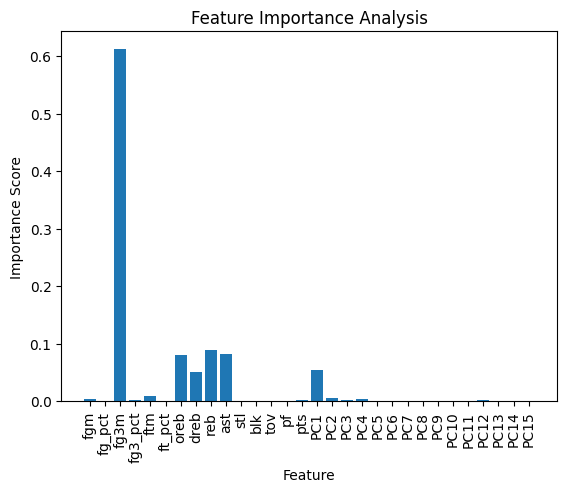

In [96]:
plt.bar(X.columns, feature_importances)
plt.ylabel('Importance Score')
plt.xlabel('Feature')
plt.title('Feature Importance Analysis')
plt.xticks(rotation=90)
plt.show()


In [97]:
X = pca_results[['fg3m', 'oreb', 'dreb', 'reb', 'ast']]
y = pca_results['num_games']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

r_squared = model.rsquared
print('R-squared:', r_squared)

R-squared: 0.42356445576098545


In [91]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              num_games   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     20.57
Date:                Tue, 05 Sep 2023   Prob (F-statistic):           9.89e-13
Time:                        13:37:45   Log-Likelihood:                -900.47
No. Observations:                 117   AIC:                             1811.
Df Residuals:                     112   BIC:                             1825.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1007.3617     58.660     17.173      0.0